In [3]:
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn import tree
import numpy as np
import skfuzzy as fuzz
from skfuzzy import control as ctrl
import warnings
warnings.filterwarnings('ignore')

# boundries
boundries = [[0.5], [36.5, 91.0], [6.05, 10.95, 11.55], [170.5, 196.0, 368.5], [3.3, 3.75, 10.25], [1.35, 2.1, 2.9],
             [0.35, 0.75, 1.05], [0.05, 0.35], [0.05], [1.7, 223.45], [20.5, 42.0], [41.5, 44.5, 62.5], 
             [45.0, 53.5, 56.5], [13.0,16.5, 169.5], [197.0, 274.5]
             ]

In [4]:
file_name = "Detection of COVID-19 Infection from Routine Blood Exams_dataset.xlsx"
df = pd.read_excel(file_name, sheet_name="Foglio1", nrows=279, usecols="A:P")

means = [61.336917562724, 8.55306859205776, 226.532129963899, 6.20047846889952, 1.18653846153846, 0.605741626794258,
         0.0550239234449761, 0.0144230769230769, 90.889010989011, 54.202166064982, 44.9172932330827, 89.8931297709924, 
         82.4779411764706, 380.448453608247]


df['SESSO'].replace(['M','F'], [0,1],inplace=True)
df['TARGET'].replace([1, 2], [1,1], inplace=True)
pure_df = df.dropna()
# pure_df = df
pure_df

,SESSO,AGE,WBC,Piastrine,Neutrofili,Linfociti,Monociti,Eosinofili,Basofili,PCR,AST,ALT,ALP,GGT,LDH,TARGET
0,0,56,2.9,128.0,1.9,0.8,0.2,0.0,0.0,29.0,36.0,18.0,43.0,21.0,257.0,1
1,0,56,3.5,151.0,2.1,0.9,0.4,0.0,0.0,16.5,25.0,14.0,50.0,17.0,207.0,1
3,0,72,16.5,316.0,14.0,1.2,0.3,0.0,0.0,318.7,96.0,33.0,80.0,42.0,651.0,1
8,0,75,11.6,123.0,10.0,0.8,0.7,0.0,0.0,244.6,53.0,37.0,43.0,27.0,439.0,1
13,0,87,8.7,93.0,6.8,1.3,0.6,0.0,0.0,201.3,36.0,28.0,73.0,63.0,375.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
259,0,36,7.7,300.0,4.5,2.2,0.8,0.2,0.0,33.1,37.0,26.0,71.0,43.0,294.0,0
267,0,59,6.8,171.0,5.7,0.7,0.5,0.0,0.0,110.2,41.0,36.0,80.0,147.0,359.0,0
270,1,81,13.0,205.0,9.4,3.0,0.5,0.0,0.1,52.1,18.0,26.0,72.0,64.0,304.0,0
273,1,30,6.8,362.0,4.5,1.9,0.4,0.0,0.0,28.1,24.0,12.0,55.0,60.0,357.0,0


In [5]:
dataset = pure_df.to_numpy()
np.random.seed(9)
train_index = np.random.rand(83) <= 0.7
test_index = np.logical_not(train_index)
train_dataset, test_dataset = dataset[train_index], dataset[test_index]

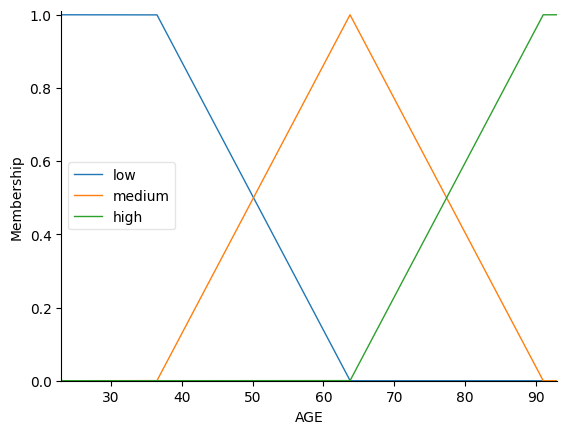

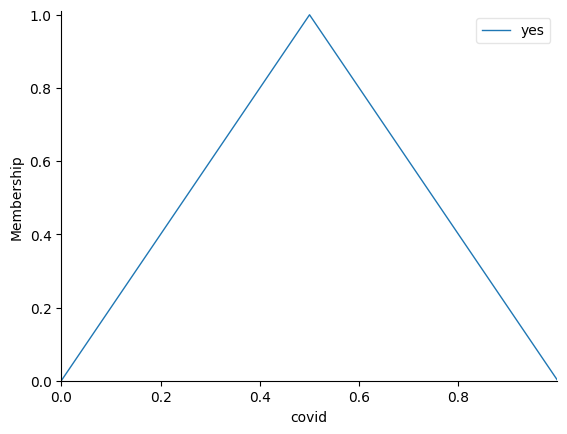

In [29]:
feature_names = ["SESSO", "AGE", "WBC", "Piastrine", "Neutrofili", "Linfociti", "Monociti", "Eosinofili", "Basofili", "PCR", "AST", "ALT", "ALP", "GGT", "LDH"]
all_features = train_dataset[:,0:-1]

all_feature_fuzzy_variables = []

for feature_index in range(15):

    # print(feature_names[feature_index] + ": ", str(boundries[feature_index]))
    feature_col = all_features[:, feature_index]
    # print(np.nanmax(feature_col), np.nanmin(feature_col))
    feature_fuzzy_variable = ctrl.Antecedent(np.arange(np.nanmin(feature_col), np.nanmax(feature_col), 0.001), feature_names[feature_index])
    bounds = boundries[feature_index]
    # print(len(bounds))
    if len(bounds) == 1:
        feature_fuzzy_variable['first'] = fuzz.trimf(feature_fuzzy_variable.universe, [np.nanmin(feature_col) - 0.5, np.nanmin(feature_col) , bounds[0]])
        feature_fuzzy_variable["second"] = fuzz.trimf(feature_fuzzy_variable.universe, [bounds[0], np.nanmax(feature_col), np.nanmax(feature_col)+0.5])
    if len(bounds) == 2:
        feature_fuzzy_variable['low'] = fuzz.trapmf(feature_fuzzy_variable.universe, [0, 0,  bounds[0], (bounds[0]+bounds[1])/2,])
        feature_fuzzy_variable['medium'] = fuzz.trimf(feature_fuzzy_variable.universe, [bounds[0], (bounds[0]+bounds[1])/2, bounds[1]])
        feature_fuzzy_variable['high'] = fuzz.trapmf(feature_fuzzy_variable.universe, [(bounds[0]+bounds[1])/2, bounds[1], np.nanmax(feature_col), np.nanmax(feature_col)])
    if len(bounds) == 3:
        # print(feature_index)
        feature_fuzzy_variable['very_low'] = fuzz.trapmf(feature_fuzzy_variable.universe, [0, 0, bounds[0], (bounds[0]+bounds[1])/2])
        feature_fuzzy_variable['low'] = fuzz.trimf(feature_fuzzy_variable.universe, [bounds[0], (bounds[0]+bounds[1])/2, bounds[1]])
        feature_fuzzy_variable['high'] = fuzz.trimf(feature_fuzzy_variable.universe, [ (bounds[0]+bounds[1])/2, bounds[1], (bounds[1]+bounds[2])/2])
        feature_fuzzy_variable['very_high'] = fuzz.trapmf(feature_fuzzy_variable.universe, [bounds[1], bounds[2], np.nanmax(feature_col), np.nanmax(feature_col)])

    all_feature_fuzzy_variables.append(feature_fuzzy_variable)

# for i in range(15):
#     all_feature_fuzzy_variables[i].view()

all_feature_fuzzy_variables[1].view()
covid = ctrl.Consequent(np.arange(0, 1, 0.001), 'covid')
covid['yes'] = fuzz.trimf(covid.universe, [0, 0.5, 1])
no_covid = ctrl.Consequent(np.arange(0,1, 0.001), 'no_covid')
no_covid['yes'] = fuzz.trimf(no_covid.universe, [0, 0.5, 1])
covid.view()
# no_covid.view()


In [17]:

def find_ling_term(feature_value, feature_index):
    bounds = boundries[feature_index]
    fuzzy_variable = all_feature_fuzzy_variables[feature_index]
    # fuzz.interp_membership(fuzzy_variable.universe, fuzzy_variable['poor'].mf, 43)
    values = []
    bounds = boundries[feature_index]
    if len(bounds) == 1:
        ling_variables = ["first", "second"]
    elif len(bounds) == 2:
        ling_variables = ["low", "medium", "high"]
    elif len(bounds) == 3:
        ling_variables = ["very_low", "low", "high", "very_high"]

    for variable in ling_variables:
        value = fuzz.interp_membership(fuzzy_variable.universe, fuzzy_variable[variable].mf, feature_value)
        values.append(value)
    max_index = values.index(max(values))
    return fuzzy_variable[ling_variables[max_index]]
    # if len(bounds) == 1:
    #     if feature_value <= bounds[0]:
    #         return all_feature_fuzzy_variables[feature_index]['first']
    #     if feature_value >= bounds[0]:
    #         return all_feature_fuzzy_variables[feature_index]['second']
    # elif len(bounds) == 2:
    #     if feature_value <= bounds[0]:
    #         return all_feature_fuzzy_variables[feature_index]['low']
    #     if feature_value >= bounds[0] and feature_value<=bounds[1]:
    #         return all_feature_fuzzy_variables[feature_index]['medium']
    #     if feature_value >= bounds[1]:
    #         return all_feature_fuzzy_variables[feature_index]['high']
    # elif len(bounds) == 3:
    #     if feature_value < bounds[0]:
    #         return all_feature_fuzzy_variables[feature_index]['very_low']
    #     if feature_value >= bounds[0] and feature_value<=bounds[1]:
    #         return all_feature_fuzzy_variables[feature_index]['low']
    #     if feature_value > bounds[1] and feature_value<=bounds[2]:
    #         return all_feature_fuzzy_variables[feature_index]['high']
    #     if feature_value>bounds[2]:
    #         return all_feature_fuzzy_variables[feature_index]['very_high']
rules = []

for sample_index in range(train_dataset.shape[0]):
    sample = train_dataset[sample_index, :]
    all_terms = find_ling_term(sample[1], 1)
    for feature_index in range(2, 10):
        all_terms &= find_ling_term(sample[feature_index], feature_index)
    rule = None

    if sample[-1] == 1:
        rule = ctrl.Rule(all_terms, covid['yes'])
    elif sample[-1] == 0:
        rule = ctrl.Rule(all_terms, no_covid['yes'])
    rules.append(rule)
print(rules)

[IF (((((((AGE[medium] AND WBC[very_low]) AND Piastrine[very_low]) AND Neutrofili[very_low]) AND Linfociti[very_low]) AND Monociti[very_low]) AND Eosinofili[low]) AND Basofili[first]) AND PCR[low] THEN covid[yes]
	AND aggregation function : fmin
	OR aggregation function  : fmax, IF (((((((AGE[medium] AND WBC[very_low]) AND Piastrine[very_low]) AND Neutrofili[very_low]) AND Linfociti[very_low]) AND Monociti[low]) AND Eosinofili[low]) AND Basofili[first]) AND PCR[low] THEN covid[yes]
	AND aggregation function : fmin
	OR aggregation function  : fmax, IF (((((((AGE[medium] AND WBC[very_high]) AND Piastrine[high]) AND Neutrofili[very_high]) AND Linfociti[very_low]) AND Monociti[very_low]) AND Eosinofili[low]) AND Basofili[first]) AND PCR[high] THEN covid[yes]
	AND aggregation function : fmin
	OR aggregation function  : fmax, IF (((((((AGE[medium] AND WBC[very_high]) AND Piastrine[very_low]) AND Neutrofili[high]) AND Linfociti[very_low]) AND Monociti[low]) AND Eosinofili[low]) AND Basofili[f

In [18]:
tipping_ctrl = ctrl.ControlSystem(rules)
tipping = ctrl.ControlSystemSimulation(tipping_ctrl)

In [19]:

for i in range (test_dataset.shape[0]):
    try:
        sample = test_dataset[i,:]

        for feature_index in range(1, 10):
            tipping.input[feature_names[feature_index]] = sample[feature_index]
        tipping.compute()
    except:
        print(i)

0
2
3
4
5
7
8
9
10
11
12
13
14
15
17
18
19
20
21


In [20]:
sample = test_dataset[10,:]
print(sample)
print(test_dataset[10,:])
for feature_index in range(1, 10):
    print(feature_names[feature_index], sample[feature_index])
    tipping.input[feature_names[feature_index]] = sample[feature_index]
# tipping.input["AGE"] = 42
# tipping.input["WBC"] = 13
# tipping.input['Piastrine'] = 170

tipping.compute()
# print(tipping.output)
# print(sample[-1])
covid.view(sim=tipping)

[  1.   70.    4.  146.    2.8   0.8   0.4   0.    0.   87.4  33.   16.
  61.   31.  318.    1. ]
[  1.   70.    4.  146.    2.8   0.8   0.4   0.    0.   87.4  33.   16.
  61.   31.  318.    1. ]
AGE 70.0
WBC 4.0
Piastrine 146.0
Neutrofili 2.8
Linfociti 0.8
Monociti 0.4
Eosinofili 0.0
Basofili 0.0
PCR 87.4


ValueError: Crisp output cannot be calculated, likely because the system is too sparse. Check to make sure this set of input values will activate at least one connected Term in each Antecedent via the current set of Rules.

[  0.   68.    7.5 253.    5.9   1.    0.5   0.    0.   56.8  36.   29.
  87.   48.  474.    1. ]
[  1.   70.    4.  146.    2.8   0.8   0.4   0.    0.   87.4  33.   16.
  61.   31.  318.    1. ]
AGE 68.0
WBC 7.5
Piastrine 253.0
Neutrofili 5.9
Linfociti 1.0
Monociti 0.5
Eosinofili 0.0
Basofili 0.0
PCR 56.8


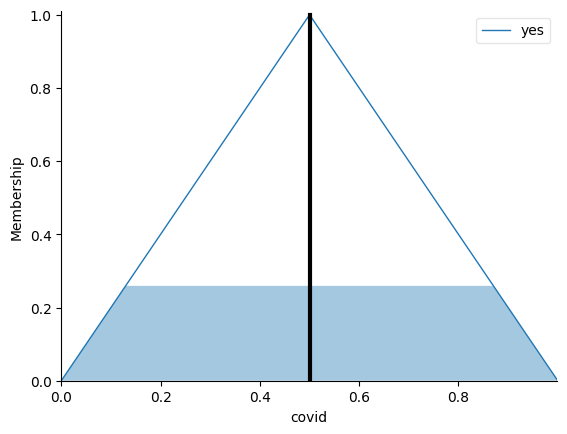

In [21]:
sample = test_dataset[1,:]
print(sample)
print(test_dataset[10,:])
for feature_index in range(1, 10):
    print(feature_names[feature_index], sample[feature_index])
    tipping.input[feature_names[feature_index]] = sample[feature_index]

tipping.compute()
covid.view(sim=tipping)

AGE 49.0
WBC 6.5
Piastrine 225.0
Neutrofili 4.8
Linfociti 1.0
Monociti 0.6
Eosinofili 0.0
Basofili 0.0
PCR 75.8


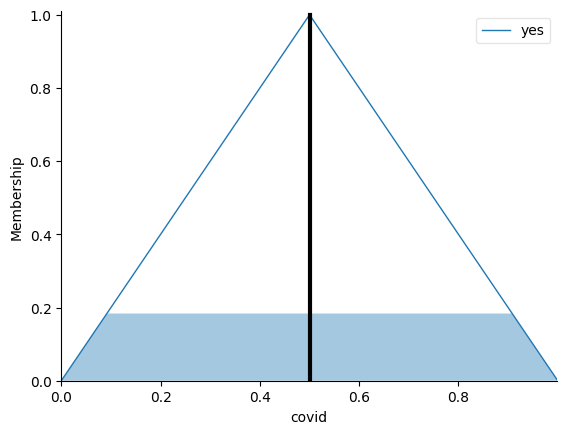

In [23]:
sample = test_dataset[16,:]
for feature_index in range(1, 10):
    print(feature_names[feature_index], sample[feature_index])
    tipping.input[feature_names[feature_index]] = sample[feature_index]
# tipping.input["AGE"] = 42
# tipping.input["WBC"] = 13
# tipping.input['Piastrine'] = 170

tipping.compute()
# print(tipping.output)
# print(sample[-1])
covid.view(sim=tipping)